In [2]:
from pyscf import gto, scf, fci
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit import QuantumCircuit
from matplotlib.ticker import ScalarFormatter
from scipy.optimize import minimize
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import Statevector
import os
from qiskit import transpile
from qiskit_aer import AerSimulator, AerProvider

from scipy.sparse.linalg import eigsh
from qiskit_ibm_runtime import QiskitRuntimeService


In [12]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService.save_account(
    token='Wx06bez50boLXEdw3IbqpoDa8gwHcURc9lQT0D_SRxJP', # Your token is confidential.
    # Do not share your key in public code.
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/624a449c58db4cebbbcd6d44cd96889e:354c61a9-e812-433b-a108-1e267e668f64::",
    name=".", # Optionally name this set of account credentials.
    set_as_default=True, # Optionally set these as your default credentials.
    overwrite=True
  )

In [14]:
service = QiskitRuntimeService()
backend = service.backend("ibm_fez")

In [ ]:
def fermion_to_qubit(problem, second_q_op, mapper_name):
    if mapper_name == "JW":
        mapper = JordanWignerMapper()
    if mapper_name == "Pa":
        mapper = ParityMapper(num_particles=problem.num_particles)
    if mapper_name == "BK":
        mapper = BravyiKitaevMapper()
    qubit_op = mapper.map(second_q_op)
    return qubit_op , mapper
    # 고전값 비교용 FCI 
    # H2 인경우로만 해뒀고, 거리 주면 에너지 계산할 수 있음. 
    
def hamming_distance(state1, state2):
    """Number of differing bits"""
    return sum(c1 != c2 for c1, c2 in zip(state1, state2))

def apply_pauli_string(state, pauli_string):
    """
    state: "010101..." (ket)
    pauli_string: "XIZY..."
    
    Returns:
        (new_state, phase factor)
    """
    state_list = list(state)
    phase = 1.0

    for i, p in enumerate(pauli_string):
        if p == 'I':
            continue
        elif p == 'Z':
            if state[i] == '1':
                phase *= -1
        elif p == 'X':
            # X → flip
            state_list[i] = '1' if state[i] == '0' else '0'
        elif p == 'Y':
            # Y → flip + phase
            if state[i] == '0':
                phase *= 1j
            else:
                phase *= -1j
            state_list[i] = '1' if state[i] == '0' else '0'

    new_state = ''.join(state_list)
    return new_state, phase

def projection_pauli_hamiltonian(pauli_op, basis_bra, basis_ket):
    """
    Compute <Phi_I | H | Phi_J> using Pauli-mapped Hamiltonian.

    pauli_op: PauliSumOp or similar (e.g. Qiskit's PauliSumOp.to_list())
    basis_bra, basis_ket: "010101..." strings
    
    Returns: float (real part of <bra|H|ket>)
    """
    total = 0.0
    
    # PauliSumOp.to_list() → list of (Pauli string, coeff)
    for pauli_string, coeff in pauli_op.to_list():
        new_state, phase = apply_pauli_string(basis_ket, pauli_string)
        if new_state == basis_bra:
            # term contribute
            total += coeff * phase
    
    return total.real
    

In [ ]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


banned_state = []




def pauli_hamiltonian_expectation_value(pauli_op, basis_bra, basis_ket):
    """
    Compute <Phi_I | H | Phi_J> using Pauli-mapped Hamiltonian.

    pauli_op: PauliSumOp or similar (e.g. Qiskit's PauliSumOp.to_list())
    basis_bra, basis_ket: "010101..." strings
    
    Returns: float (real part of <bra|H|ket>)
    """
    total = 0.0
    
    # PauliSumOp.to_list() → list of (Pauli string, coeff)
    for pauli_string, coeff in pauli_op.to_list():
        new_state, phase = apply_pauli_string(basis_ket, pauli_string)
        if new_state == basis_bra:
            # term contribute
            total += coeff * phase
    
    return total.real







    




def projection_hamiltonian(basis_list, hamiltonian):
    n = len(basis_list)

    H = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            basis_bra = basis_list[i]
            basis_ket = basis_list[j]
            inner_product = pauli_hamiltonian_expectation_value(hamiltonian, basis_bra , basis_ket)
            H_ij = np.real(inner_product)
            H[i, j] = H_ij 
    return H

def Screening(basis_list, hamiltonian,k):
    projected_hamiltonian = projection_hamiltonian(basis_list, hamiltonian)
    eigenvalue, eigenvector = eigsh(projected_hamiltonian, k=1, which='SA', tol=1e-1)

    v = eigenvector[:, 0]

    # 3. 절댓값 기준으로 top-k index 선택
    top_k_indices = np.argsort(np.abs(v))[::-1][:k]

    # 4. A에서 해당 index의 행과 열 뽑아서 k x k 정방행렬 만들기
    A_reduced = projected_hamiltonian[np.ix_(top_k_indices, top_k_indices)]
    print(f"Top-{k} indices (by |v_i|):", top_k_indices)
    print("A_reduced (k x k):")
    print(A_reduced)
    return A_reduced


def Energy_calc








SyntaxError: invalid syntax (1897962445.py, line 92)

In [ ]:
def Circuit_Preperation(hamiltonian, E_problem,mapper, which_ansatz):
    #헤밀토니안이랑 driver 주어지면, 회로 생성. 
    num_qubits = hamiltonian.num_qubits
    num_particles = E_problem.num_particles
    num_electrons = np.sum(num_particles)
    num_spatial_orbitals = E_problem.num_spatial_orbitals
    init_state = HartreeFock(num_spatial_orbitals,num_particles, mapper)
    if which_ansatz == "UCCSD":
        ansatz = UCCSD(num_spatial_orbitals,num_particles,mapper,initial_state=init_state)
    elif which_ansatz == "twolocal": 
        ansatz = TwoLocal(num_spatial_orbitals*2, ['ry', 'rz'], 'cz', initial_state=init_state)
    else : 
        print("ansatz 입력 틀림 UCCSD or twolocal ")
    
    return ansatz

def sampling_Filtering(ansatz, parameter, backend, n_ptl):
    # 측정해서 spin이랑 그런거 맞는거만 필터링
    global convergence_state
    global cost_history_dict 
    global repulsion
    global banned_state
    params = ansatz.parameters 
    param_dict = dict(zip(params, parameter))
    qc = ansatz.assign_parameters(param_dict)
    qc.measure_all()

    job = backend.run(transpile(qc, backend), shots=20000)
    result = job.result()

    # Counts 얻기
    counts = result.get_counts(qc)
    total_shots = sum(counts.values())
    probs = [(bitstring, count / total_shots) for bitstring, count in counts.items()]

    all_basis = []
    all_prob = []
    for bitstring, prob in probs:
        count_ones = bitstring.count('1')
        half = len(bitstring) // 2
        left_ones = bitstring[:half].count('1')
        right_ones = bitstring[half:].count('1')
        if count_ones == n_ptl and left_ones==right_ones :
            all_basis.append(bitstring)
            all_prob.append(prob)

    all_basis = np.array(all_basis)
    print(len(all_basis))
    all_prob = np.array(all_prob)
    
    
def screening(all_basis,hamiltonian,k):
    n = len(all_basis)
    H = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            basis_bra = all_basis[i]
            basis_ket = all_basis[j]
            inner_product = projection_pauli_hamiltonian(hamiltonian, basis_bra , basis_ket)
            H_ij = np.real(inner_product)
            H[i, j] = H_ij 
            #print("<{}|H|{}> = {}".format(basis_bra,basis_ket,H_ij))
    eigenvalue, eigenvector = eigsh(H, k=1, which='SA')  # SA: smallest algebraic
    v0 = eigenvector[:, 0]  # 가장 작은 고유값에 대응하는 고유벡터
    indices = np.argsort(np.abs(v0))[-k:]  # 절댓값 기준으로 큰 순서대로 k개
    important_states = indices[::-1]  # 큰 순서대로 정렬
    print(important_states)
    for idx in important_states:
        print(f"index={idx}, coeff={v0[idx]}")


In [ ]:
cost_history_dict["iters"] += 1
cost_history_dict["prev_vector"] = params
cost_history_dict["cost_history"].append(Energy)
print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {Energy+repulsion}]")

In [ ]:
def cost_func(parameter, second_q_op, n_ptl, ansatz, backend,k):
    global convergence_state
    global cost_history_dict 
    global repulsion
    global banned_state
    

    Circuit_Preperation(hamiltonian, E_problem, mapper, "UCCSD")



    n = len(probable_basis)

    H = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            basis_bra = probable_basis[i]
            basis_ket = probable_basis[j]
            inner_product = projection_pauli_hamiltonian(second_q_op, basis_bra , basis_ket)
            H_ij = np.real(inner_product)
            H[i, j] = H_ij 
            #print("<{}|H|{}> = {}".format(basis_bra,basis_ket,H_ij))
    eigvals, eigvecs = np.linalg.eig(H)
    Energy = np.min(eigvals)

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(Energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {Energy+repulsion}]")

    prev = convergence_state["prev_cost"]
    """
    if convergence_state["streak"] >= convergence_state["patience"]:
        print("✅ 조기 수렴 조건 충족: 최적화 강제 종료")
        raise ConvergenceReached()

    if prev is not None and abs(Energy - prev) < convergence_state["tol"]:
        convergence_state["streak"] += 1
    else:
        convergence_state["streak"] = 0
    convergence_state["prev_cost"] = Energy

    if convergence_state["streak"] >= convergence_state["patience"]:
        convergence_state["trigger_stop"] = True
        print("✅ 조기 수렴 조건 충족: 최적화 중단 예정")
    """

    return Energy


In [3]:
#api_key = "7IMO85iuzmzAAgri4osG5BPTeCFXrKoM"
#provider = IonQProvider(api_key)
#backend = provider.get_backend("simulator")
#simulator_backend = provider.get_backend("qpu.forte-1")


backend = AerSimulator(method = "statevector",noise_model=None)

In [4]:


# To run on hardware, select the backend with the fewest number of jobs in the queue
#service = QiskitRuntimeService(channel="ibm_quantum", token ='55ac54cb4cbfe378d8604606bacfcab38ffd165ecdb215742e64495a259fa53f0ed9e63df5b3df4489d422865a007d9cc981fcb2caffd9e76f17d94d734a8593')
#backend = service.least_busy(operational=True, simulator=False)
#backend = GenericBackendV2(num_qubits=5)

#backend = AerSimulator(method = "statevector",noise_model=None)

In [5]:
atoms = ["Li", "H"]
basis = 'sto-3g'
dist = 1.595
coords = [(0,0,0), (dist,0,0)]
charge = 0
multiplicity = 1
Co_O_moleculeinfo = MoleculeInfo(atoms, coords, charge=charge, multiplicity=multiplicity)
#active_transformer = ActiveSpaceTransformer(4,4)
driver = PySCFDriver.from_molecule(Co_O_moleculeinfo, basis=basis)
E_problem = driver.run() 
# Transformer 적용
#E_problem = active_transformer.transform(problem)

# 여기는 이후, As_transformer 로 변경. 
fermionic_hamiltonian = E_problem.hamiltonian
second_q_op = fermionic_hamiltonian.second_q_op()
print(second_q_op)

Fermionic Operator
number spin orbitals=12, number terms=1860
  -4.728421350668939 * ( +_0 -_0 )
+ 0.10568279317546274 * ( +_0 -_1 )
+ 0.16702010714840393 * ( +_0 -_2 )
+ -0.034287134413124976 * ( +_0 -_5 )
+ 0.10568279317546271 * ( +_1 -_0 )
+ -1.4945774367765843 * ( +_1 -_1 )
+ 0.033033106228435576 * ( +_1 -_2 )
+ -0.05410240910958546 * ( +_1 -_5 )
+ 0.16702010714840385 * ( +_2 -_0 )
+ 0.033033106228435555 * ( +_2 -_1 )
+ -1.125883391287568 * ( +_2 -_2 )
+ 0.03053995599123462 * ( +_2 -_5 )
+ -1.1362676334780764 * ( +_3 -_3 )
+ -1.136267633478076 * ( +_4 -_4 )
+ -0.03428713441312494 * ( +_5 -_0 )
+ -0.054102409109585324 * ( +_5 -_1 )
+ 0.03053995599123433 * ( +_5 -_2 )
+ -0.9501040287604593 * ( +_5 -_5 )
+ -4.728421350668939 * ( +_6 -_6 )
+ 0.10568279317546274 * ( +_6 -_7 )
+ 0.16702010714840393 * ( +_6 -_8 )
+ -0.034287134413124976 * ( +_6 -_11 )
+ 0.10568279317546271 * ( +_7 -_6 )
+ -1.4945774367765843 * ( +_7 -_7 )
+ 0.033033106228435576 * ( +_7 -_8 )
+ -0.05410240910958546 * ( +_7

Probabilities: [('101000001100', 5e-05), ('100010000101', 5e-05), ('000011001100', 5e-05), ('001100000101', 5e-05), ('000011100100', 0.0002), ('010100100100', 5e-05), ('011000001100', 5e-05), ('001100100001', 0.00045), ('000011100001', 0.0001), ('001001010001', 0.0001), ('000110010001', 0.00015), ('010100100010', 5e-05), ('100100100100', 0.00025), ('101000100010', 0.00025), ('100010000011', 0.00035), ('110000000101', 0.00015), ('101000100100', 0.00025), ('001001000110', 0.00035), ('000110001100', 0.0001), ('010100000101', 0.0001), ('110000010100', 0.0003), ('101000001001', 5e-05), ('000101100100', 0.00015), ('000101000011', 0.0003), ('000101001010', 0.0002), ('110000010001', 0.00075), ('110000000011', 0.0018), ('011000000101', 0.00085), ('010010000101', 0.0003), ('101000010100', 5e-05), ('001010001010', 0.0016), ('011000100100', 0.0005), ('010001000110', 0.00045), ('010001110000', 0.0002), ('100010000110', 0.00115), ('100010011000', 0.00085), ('110000001010', 0.0002), ('001010000110', 

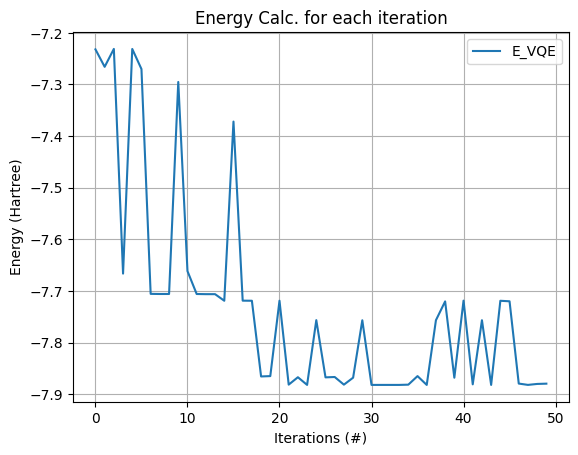

In [6]:
fermionic_hamiltonian = E_problem.hamiltonian
second_q_op = fermionic_hamiltonian.second_q_op()
repulsion = fermionic_hamiltonian.constants['nuclear_repulsion_energy']
hamiltonian, mapper = fermion_to_qubit(E_problem, second_q_op, "JW")
#H_op = hamiltonian.to_operator()
#H_matrix = H_op.data

num_qubits = hamiltonian.num_qubits
num_particles = E_problem.num_particles
num_electrons = np.sum(num_particles)
num_spatial_orbitals = E_problem.num_spatial_orbitals



init_state = HartreeFock(num_spatial_orbitals,num_particles, mapper)
#ansatz = TwoLocal(num_spatial_orbitals*2, ['ry', 'rz'], 'cz', initial_state=init_state).decompose()
ansatz = UCCSD(num_spatial_orbitals,num_particles,mapper,initial_state=init_state)

pauli_basis = hamiltonian.paulis
coeffs = hamiltonian.coeffs
num_params = ansatz.num_parameters

""""
x0 = 2 * np.pi * np.random.random(num_params)

res = minimize(
    cost_func,
    x0,
    args=(second_q_op, num_electrons, ansatz, simulator_backend, 4),
    method="cobyla",
)

"""

bounds = [(0, 2*np.pi)] * num_params  # ansatz 파라미터 수에 따라 조절


x0 = 2 * np.pi * np.random.random(num_params)

res = minimize(
    cost_func,
    x0,
    args=(hamiltonian, num_electrons, ansatz, backend, 50),
    method="cobyla",
    options={
        "maxiter": 50,      # 적당히 설정
        "tol": 1e-3          # 너무 엄격하게 하지 않기
    }
)

"""

try:
    res = differential_evolution(
        func=lambda w: cost_func(w, hamiltonian, num_electrons, ansatz, backend,20),
        bounds=bounds,
        callback=early_stop_callback,
        polish=True,
    )
except ConvergenceReached:
    print("🔁 최적화가 조기 수렴 조건에 따라 종료되었습니다.")
"""

plt.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"] + repulsion, label='E_VQE')
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
plt.xlabel("Iterations (#)")
plt.ylabel("Energy (Hartree)")
plt.title("Energy Calc. for each iteration")
plt.legend()
plt.grid()
plt.draw()

In [ ]:

ansatz = Circuit_Preperation(hamiltonian, E_problem, mapper, 'uccsd')
num_params = ansatz.num_parameters


all_basis = sampling_Filtering(ansatz, x0, backend, num_electrons)
screened_space = screening(all_basis, hamiltonian, 150)
Energy, ground_state = energy_calc(screened_space,hamiltonian)
post_screened_space = post_screening(ground_state, screened_space, eps)
ith_space,expanded_space = classical_expansion(ground_state,screened_space)

print(Energy)
print(ith_space)